# Surf boards analyse


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
import lightgbm as lgb
import xgboost as xgb

## Getting Data

In [2]:
import gdown

# URL to the file on Google Drive
google_drive_url = 'https://drive.google.com/uc?id=1VAVMLCXETnftWBYJbEXbcuktqNElRgcF'

# Path to save the file
output_path = '/content/df_surf.csv'

# Download and save the file
gdown.download(google_drive_url, output_path, quiet=False)

# Check if the file has been downloaded
import os
if os.path.exists(output_path):
    print(f"The file has been downloaded and saved as {output_path}")
else:
    print("Downloading the file failed.")


Downloading...
From: https://drive.google.com/uc?id=1VAVMLCXETnftWBYJbEXbcuktqNElRgcF
To: /content/df_surf.csv
100%|██████████| 55.8k/55.8k [00:00<00:00, 47.3MB/s]

The file has been downloaded and saved as /content/df_surf.csv


In [3]:
# Load the data
df_surf = pd.read_csv('/content/df_surf.csv')

# Display the first few rows of the data
df_surf.head()

,Unnamed: 0,board_adequate,board_how_many,board_length,board_nose_rocker,board_nose_shape,board_tail_rocker,board_tail_shape,board_thickness,board_type,...,surfer_height,surfer_style,surfer_weight,surfer_weight_distribution,wave_height,wave_shape,wave_height_min,wave_height_max,wave_height_mean,wave_height_interval
0,0,More or less,5.0,1.8034,4.75,Pointed,2.3125,"Outward (Round, Round-Pin, Pin)",2.3125,Shortboard,...,1.72,Neutral,78.0,NaN,3,Spilling/Plunging,3.0,3.0,3.0,0.0
1,1,More or less,1.0,1.9304,NaN,Pointed,NaN,"Neutral (Squash, Square)",NaN,All-around,...,1.58,Smooth (recreative),54.0,NaN,2,Spilling,2.0,2.0,2.0,0.0
2,2,Very suitable,3.0,1.7272,NaN,Pointed,NaN,"Neutral (Squash, Square)",2.5625,Shortboard,...,1.73,Neutral,75.0,NaN,"2, 5","Spilling, Spilling/Plunging, Plunging",2.0,5.0,3.5,3.0
3,3,Very suitable,1.0,1.8034,NaN,Pointed,NaN,"Neutral (Squash, Square)",2.4375,Shortboard,...,1.76,Neutral,76.0,NaN,"3, 6","Spilling, Spilling/Plunging, Plunging",3.0,6.0,4.5,3.0
4,4,Suitable,5.0,1.7780,NaN,Pointed,NaN,"Inward (Fish-tail, Swallow, Bat wing, Half moon)",NaN,All-around,...,1.77,Neutral,84.0,NaN,5,Spilling/Plunging,5.0,5.0,5.0,0.0


## Data Cleaning And Feature Engineering


In [4]:
# Dropping 'Unnamed: 0' column
df_surf = df_surf.drop('Unnamed: 0', axis=1)

In [5]:
# Basic statistics for the numeric columns
df_surf.describe()

,board_how_many,board_length,board_nose_rocker,board_tail_rocker,board_thickness,board_volume,board_width,performance_manoeuvrability,surfer_age,surfer_height,surfer_weight,surfer_weight_distribution,wave_height_min,wave_height_max,wave_height_mean,wave_height_interval
count,158.000000,156.000000,17.000000,15.000000,106.000000,101.000000,108.000000,162.000000,161.000000,163.000000,161.000000,0.0,163.000000,163.000000,163.000000,163.000000
mean,3.234177,1.812355,3.647647,2.491667,2.467925,30.852970,19.434028,0.776749,34.571429,1.757301,75.152174,NaN,3.748466,4.276074,4.012270,0.527607
std,4.850855,0.122506,0.635819,0.303317,0.244309,7.819819,0.983585,0.206154,7.927574,0.073283,10.538774,NaN,1.101870,1.049917,0.971747,0.925048
min,1.000000,1.549400,3.125000,1.562500,2.000000,22.000000,18.000000,0.166667,16.000000,1.570000,36.000000,NaN,2.000000,2.000000,2.000000,0.000000
25%,2.000000,1.752600,3.250000,2.500000,2.312500,27.000000,18.750000,0.666667,29.000000,1.710000,70.000000,NaN,3.000000,4.000000,3.000000,0.000000
50%,2.000000,1.803400,3.250000,2.500000,2.375000,28.800000,19.250000,0.833333,33.000000,1.760000,75.000000,NaN,4.000000,4.000000,4.000000,0.000000
75%,4.000000,1.854200,4.125000,2.750000,2.590625,32.300000,19.781250,1.000000,39.000000,1.800000,80.000000,NaN,5.000000,5.000000,5.000000,1.000000
max,60.000000,2.438400,4.750000,2.750000,3.625000,83.500000,22.500000,1.000000,57.000000,1.940000,120.000000,NaN,6.000000,6.000000,6.000000,4.000000


In [6]:
# Analysis of missing values
missing_values = df_surf.isnull().sum()
missing_percentage = (df_surf.isnull().sum() / df_surf.shape[0]) * 100

# Creating a DataFrame with information on missing values
missing_data = pd.DataFrame({
    'Total missing values': missing_values,
    'Percentage of missing values': missing_percentage
})

# Sorting the DataFrame to show columns with the highest number of missing values
missing_data = missing_data.sort_values(by='Percentage of missing values', ascending=False)
print(missing_data.head(10))

                              Total missing values  \
surfer_weight_distribution                     164   
board_tail_rocker                              149   
board_nose_rocker                              147   
board_volume                                    63   
board_thickness                                 58   
board_width                                     56   
manoeuvres_03_straight_ahead                    19   
manoeuvres_10_air                                9   
board_length                                     8   
board_how_many                                   6   

                              Percentage of missing values  
surfer_weight_distribution                      100.000000  
board_tail_rocker                                90.853659  
board_nose_rocker                                89.634146  
board_volume                                     38.414634  
board_thickness                                  35.365854  
board_width                            

In [7]:
# Drop only the top 3 columns with the highest missing values
columns_to_drop = missing_data.head(3).index.tolist()
df_cleaned = df_surf.drop(columns=columns_to_drop)
df_cleaned.shape

(164, 40)

In [8]:
# Replace missing values in numeric columns with the median
for column in df_cleaned.select_dtypes(include=['float64', 'int64']):
    df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)


In [9]:
# Replace missing values in categorical columns with the mode
for column in df_cleaned.select_dtypes(include=['object']):
    df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)

In [10]:
# Apply label encoding to categorical columns
label_encoders = {}
for column in df_cleaned.select_dtypes(include=['object']):
    le = LabelEncoder()
    df_cleaned[column] = le.fit_transform(df_cleaned[column])
    label_encoders[column] = le


In [11]:
# Check for zero values in 'board_width' and replace them with its median
median_width = df_cleaned['board_width'].median()
df_cleaned['board_width'].replace(0, median_width, inplace=True)


In [12]:
# Create the 'board_volume_to_width' feature
df_cleaned['board_volume_to_width'] = df_cleaned['board_volume'] / df_cleaned['board_width']


In [13]:
# Normalize the features using StandardScaler
scaler = StandardScaler()
df_processed = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

df_processed.head()

,board_adequate,board_how_many,board_length,board_nose_shape,board_tail_shape,board_thickness,board_type,board_volume,board_width,manoeuvres_01_paddling,...,surfer_height,surfer_style,surfer_weight,wave_height,wave_shape,wave_height_min,wave_height_max,wave_height_mean,wave_height_interval,board_volume_to_width
0,-1.063132,0.381109,-0.071515,-0.501231,1.064408,-0.611371,0.837122,-0.543742,-1.324593,-0.584765,...,-0.512348,0.019594,0.273847,-0.806586,0.717419,-0.684740,-1.221012,-1.048033,-0.569799,-0.306555
1,-1.063132,-0.460667,0.994703,-0.501231,-0.268133,-0.299602,-1.384366,-0.204341,-0.151627,1.783173,...,-2.434490,1.090711,-2.031743,-2.126745,-1.150147,-1.597727,-2.179126,-2.083440,-0.569799,-0.180022
2,1.619232,-0.039779,-0.711245,-0.501231,-0.268133,0.635704,0.837122,0.070413,1.255932,-0.584765,...,-0.375052,0.019594,-0.014351,-1.334649,0.094897,-1.597727,0.695217,-0.530330,2.689981,-0.177269
3,1.619232,-0.460667,-0.071515,-0.501231,-0.268133,0.012167,0.837122,0.086575,0.004768,-0.584765,...,0.036835,0.019594,0.081715,-0.014490,0.094897,-0.684740,1.653332,0.505076,2.689981,0.096582
4,-0.169011,0.381109,-0.284758,-0.501231,-1.600674,-0.299602,-1.384366,-0.204341,-0.151627,-0.584765,...,0.174131,0.019594,0.850245,1.041638,0.717419,1.141234,0.695217,1.022779,-0.569799,-0.180022


## Surfing Performance Factors Visualisation


### Setting Features And Targets

In [14]:
# Extract feature and target columns from the dataframe
targets = ['performance_ease_paddling', 'performance_flotation', 'performance_hold',
          'performance_manoeuvrability', 'performance_passing_through',
          'performance_stability', 'performance_surf_speed', 'performance_control']


target = df_processed[targets]
features = df_processed.drop(target, axis=1)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)



In [51]:
def plot_feature_importance(model_class, params, X, y, target_name, model_name):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    mae_scores = []
    feature_importance_dfs = []

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model = model_class(**params)
        model.fit(X_train_fold, y_train_fold)

        predictions = model.predict(X_test_fold)
        rmse_scores.append(mean_squared_error(y_test_fold, predictions, squared=False))
        mae_scores.append(mean_absolute_error(y_test_fold, predictions))

        feature_importance = model.feature_importances_ if hasattr(model, "feature_importances_") else model.coef_

        feature_importances = pd.DataFrame({
            'column': X.columns,
            'feature_importance': feature_importance
        })
        feature_importance_dfs.append(feature_importances)

    # Average feature importance
    df_feature_importance = pd.concat(feature_importance_dfs)
    order = df_feature_importance.groupby('column').sum().sort_values(by='feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=df_feature_importance, x='feature_importance', y='column', order=order, ax=ax, palette='viridis', orient='h')
    ax.tick_params(axis='x', rotation=0)
    ax.set_title(f'Feature Importances for {target_name} using {model_name}')
    ax.grid()
    fig.tight_layout()

    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)

    print(f"Average RMSE for {model_name} on {target_name}: {avg_rmse:.4f}")
    print(f"Average MAE for {model_name} on {target_name}: {avg_mae:.4f}")
    print("-" * 50)

    return avg_rmse, avg_mae


### Random Forest Model

Average RMSE for Random Forest on performance_ease_paddling: 1.0146
Average MAE for Random Forest on performance_ease_paddling: 0.8929
--------------------------------------------------
Average RMSE for Random Forest on performance_flotation: 1.0597
Average MAE for Random Forest on performance_flotation: 0.8919
--------------------------------------------------
Average RMSE for Random Forest on performance_hold: 1.0242
Average MAE for Random Forest on performance_hold: 0.8939
--------------------------------------------------
Average RMSE for Random Forest on performance_manoeuvrability: 0.7412
Average MAE for Random Forest on performance_manoeuvrability: 0.5898
--------------------------------------------------
Average RMSE for Random Forest on performance_passing_through: 1.0621
Average MAE for Random Forest on performance_passing_through: 0.9275
--------------------------------------------------
Average RMSE for Random Forest on performance_stability: 1.0413
Average MAE for Random F

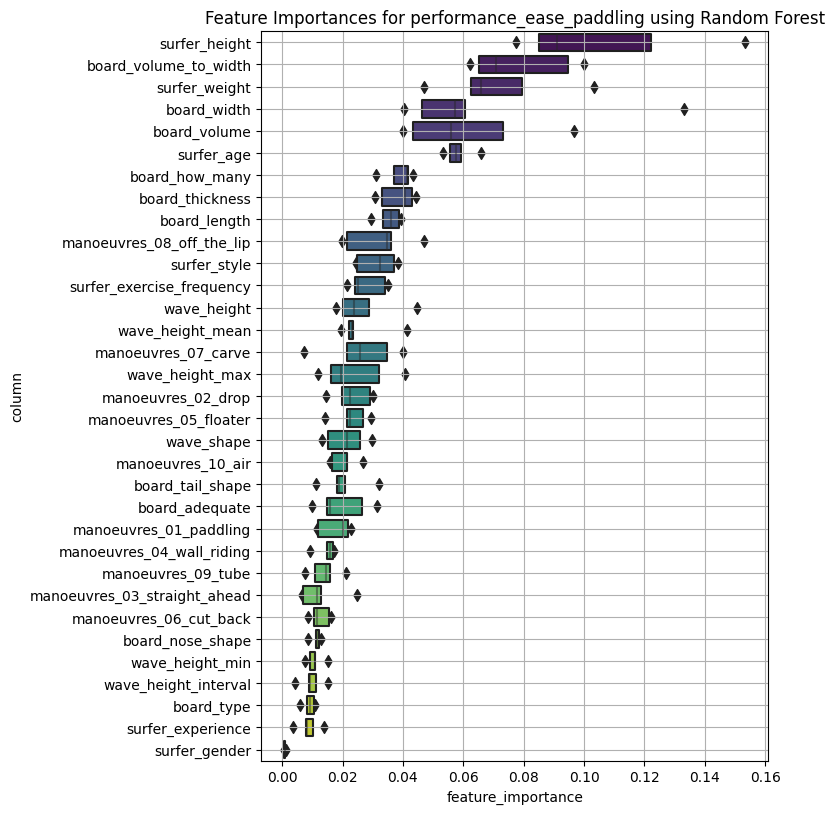

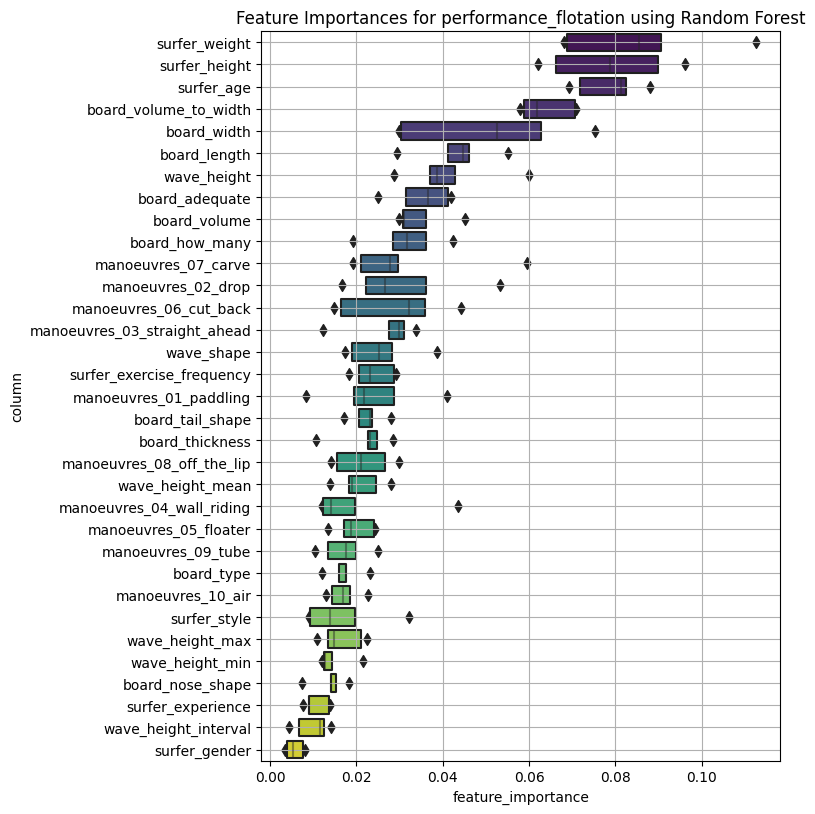

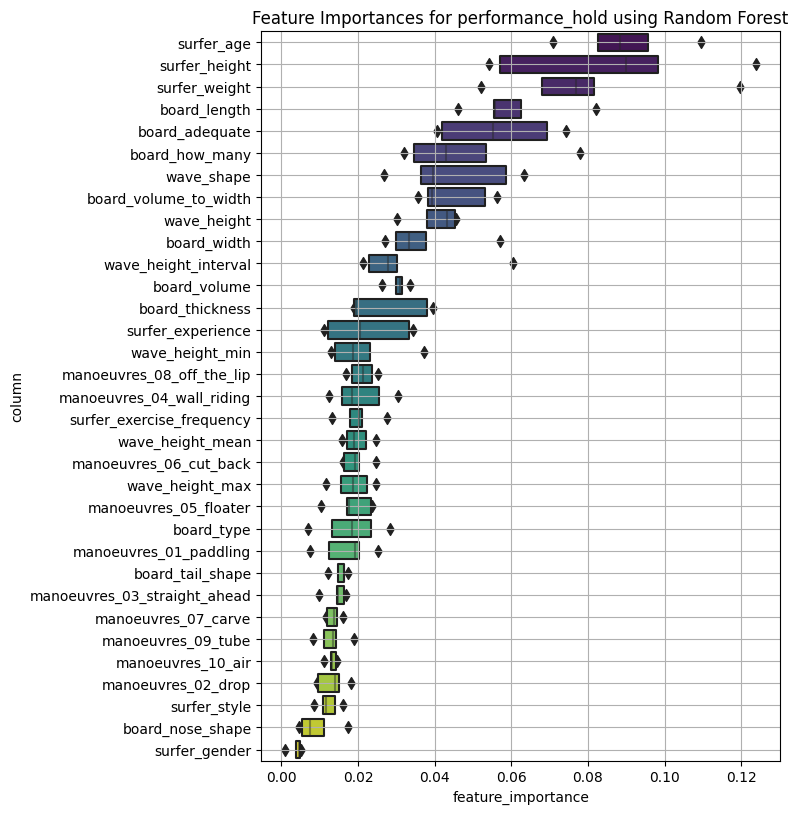

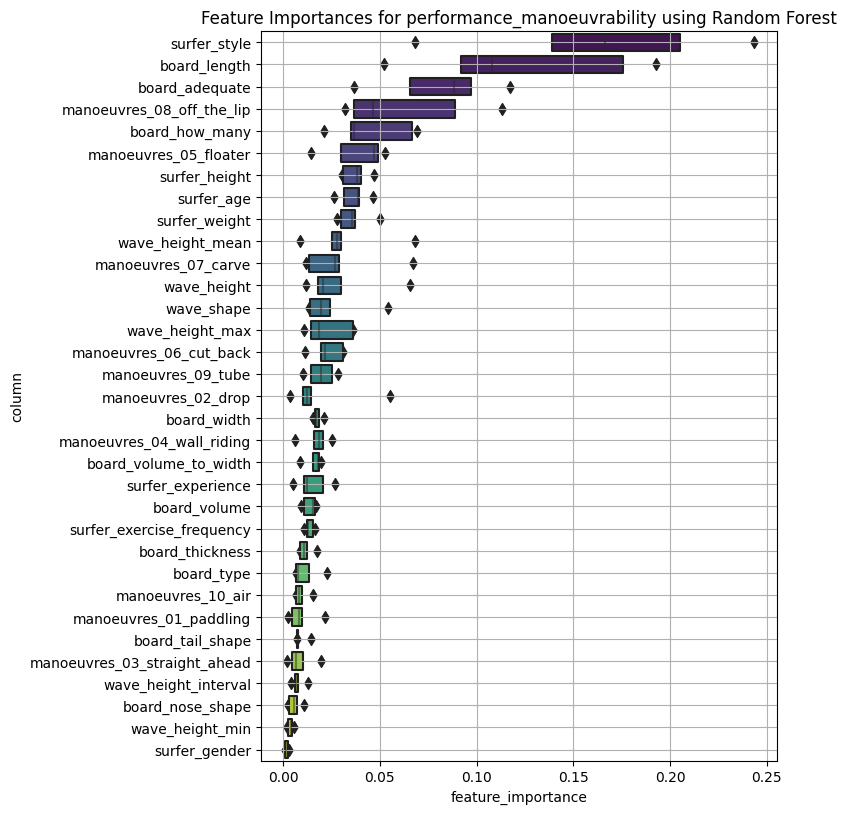

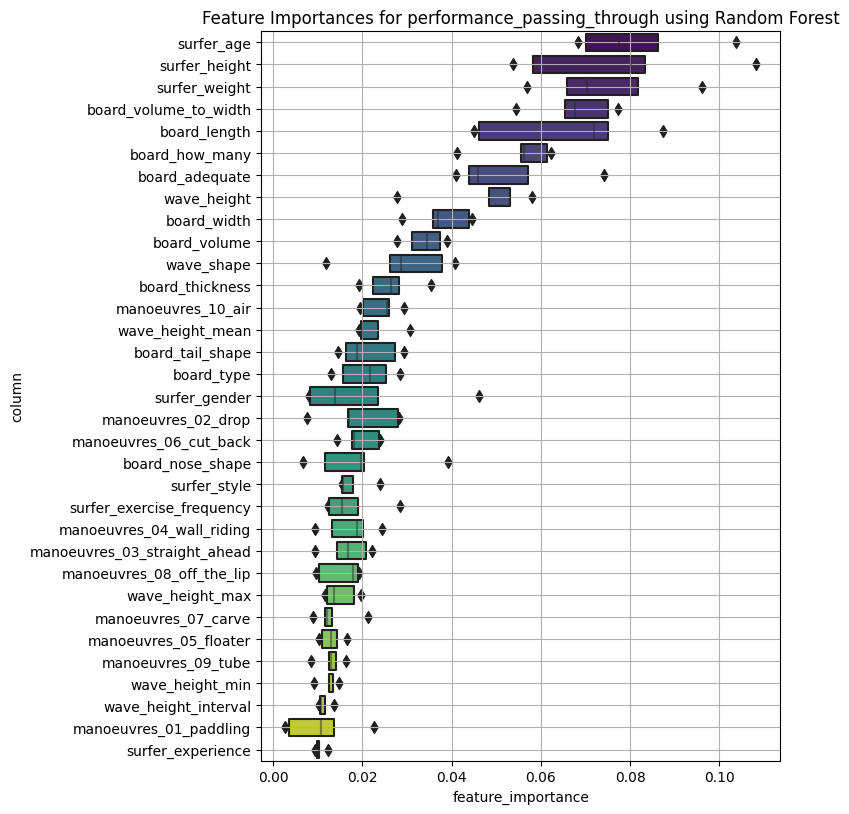

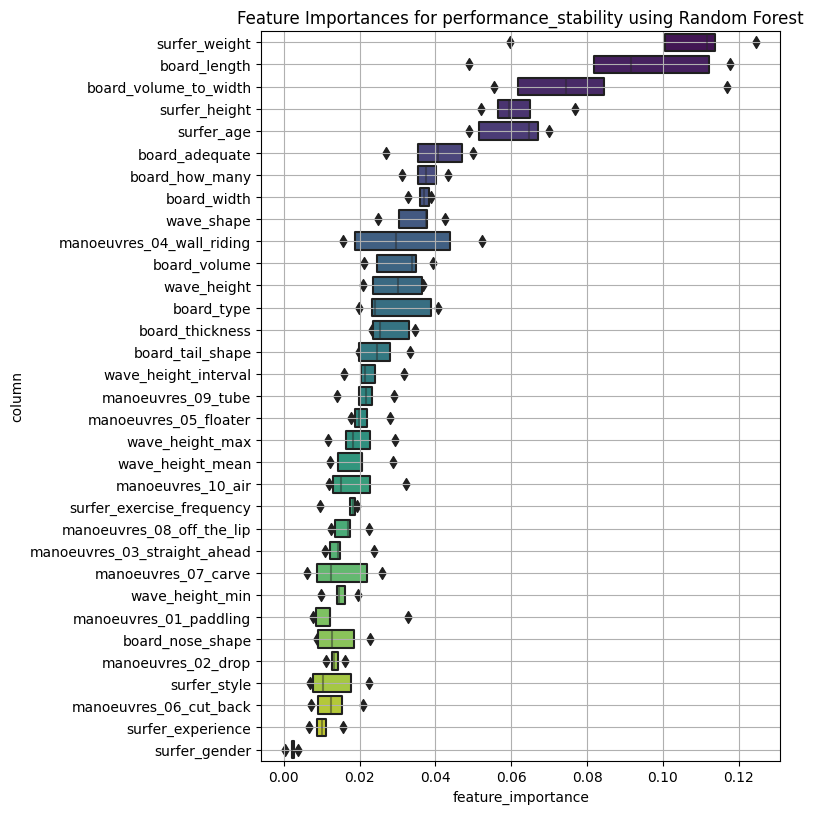

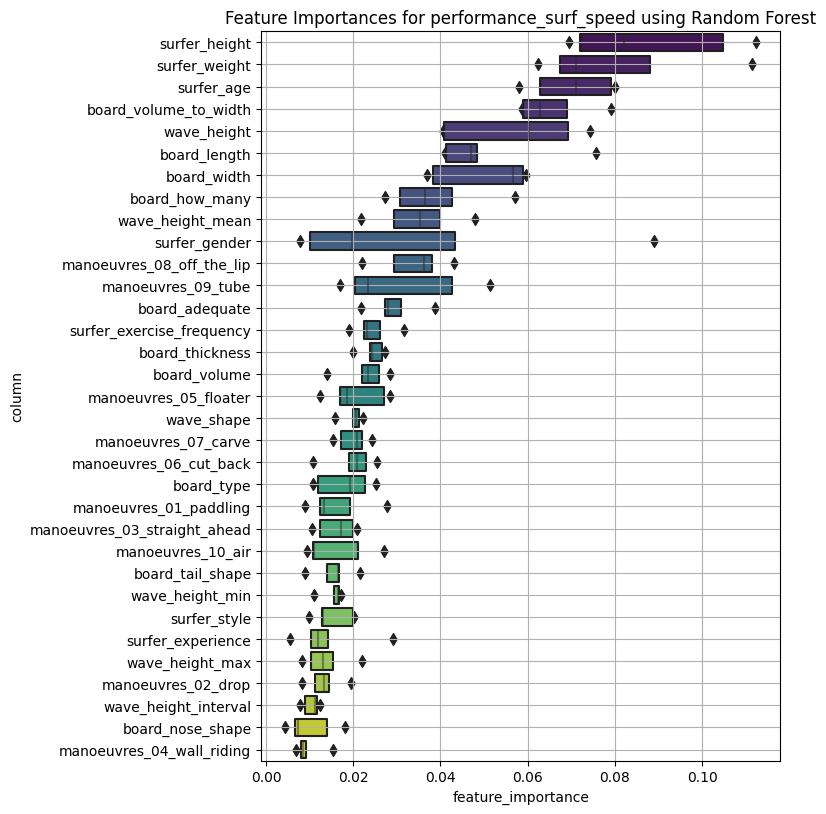

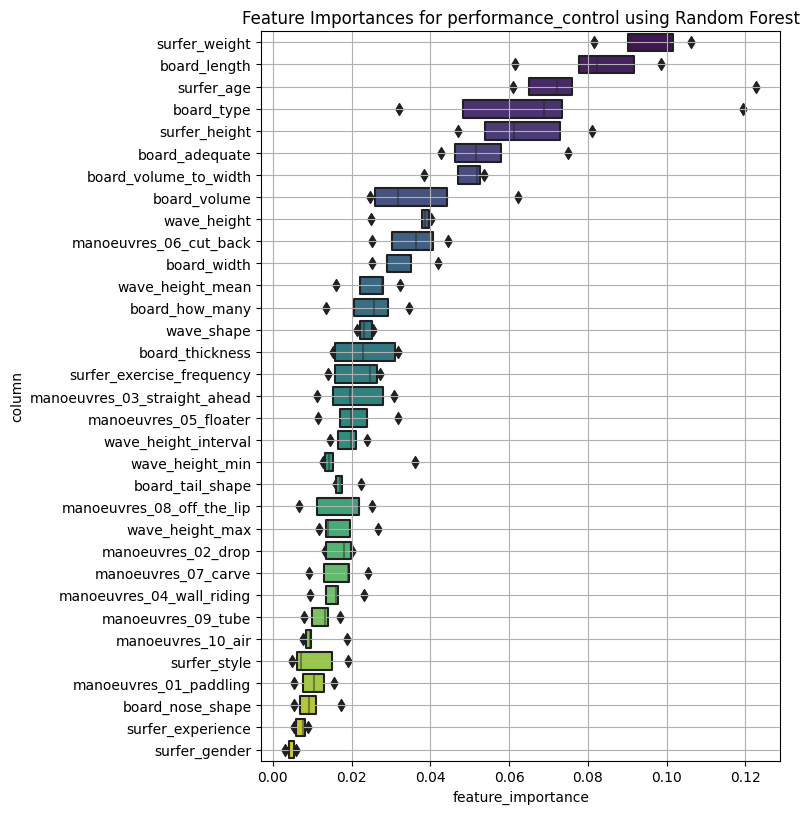

In [52]:
params_rf = {
    'n_estimators': 100,
    'random_state': 42
}

for target_column in targets:
    plot_feature_importance(RandomForestRegressor, params_rf, X_train, y_train[target_column], target_column, model_name='Random Forest')


### XGBoost Model

Average RMSE for XGBoost on performance_ease_paddling: 1.1629
Average MAE for XGBoost on performance_ease_paddling: 0.9746
--------------------------------------------------
Average RMSE for XGBoost on performance_flotation: 1.2443
Average MAE for XGBoost on performance_flotation: 1.0497
--------------------------------------------------
Average RMSE for XGBoost on performance_hold: 1.0899
Average MAE for XGBoost on performance_hold: 0.9054
--------------------------------------------------
Average RMSE for XGBoost on performance_manoeuvrability: 0.7941
Average MAE for XGBoost on performance_manoeuvrability: 0.6228
--------------------------------------------------
Average RMSE for XGBoost on performance_passing_through: 1.1945
Average MAE for XGBoost on performance_passing_through: 0.9879
--------------------------------------------------
Average RMSE for XGBoost on performance_stability: 1.1154
Average MAE for XGBoost on performance_stability: 0.9323
---------------------------------

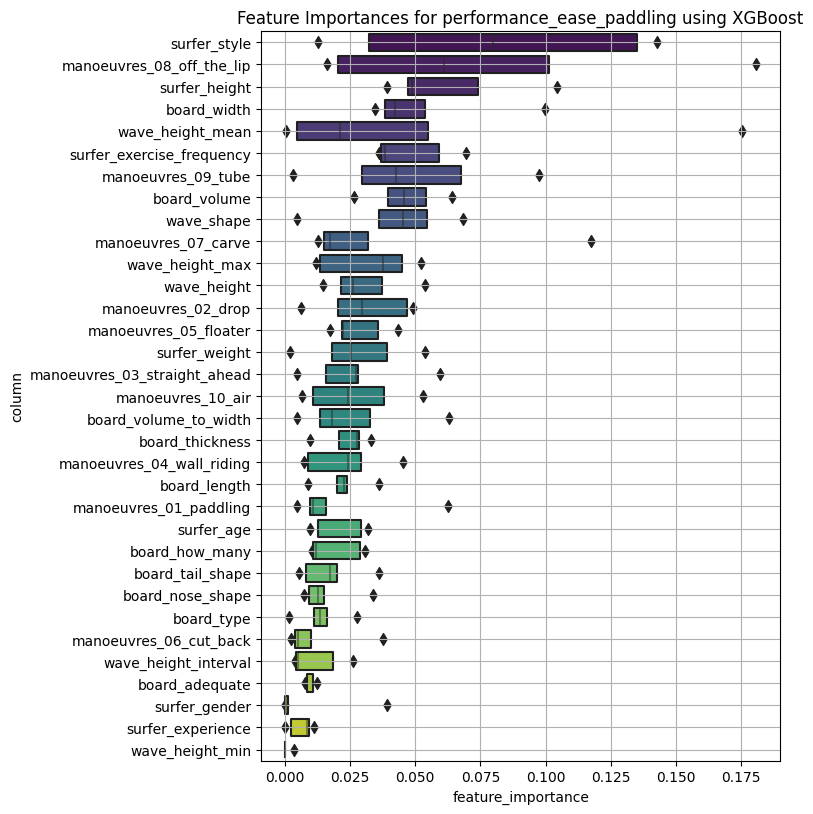

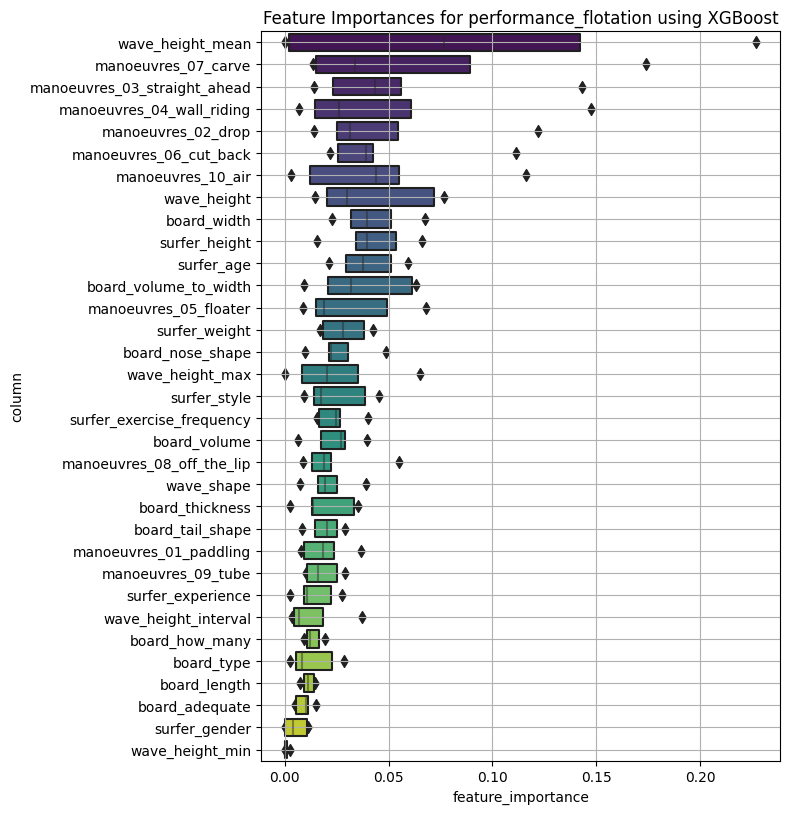

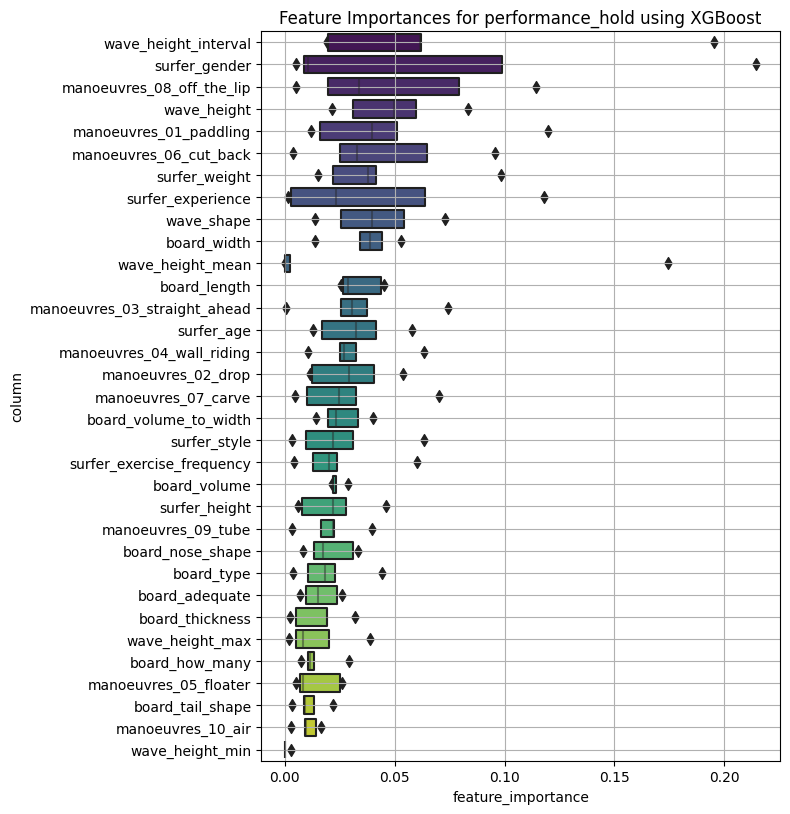

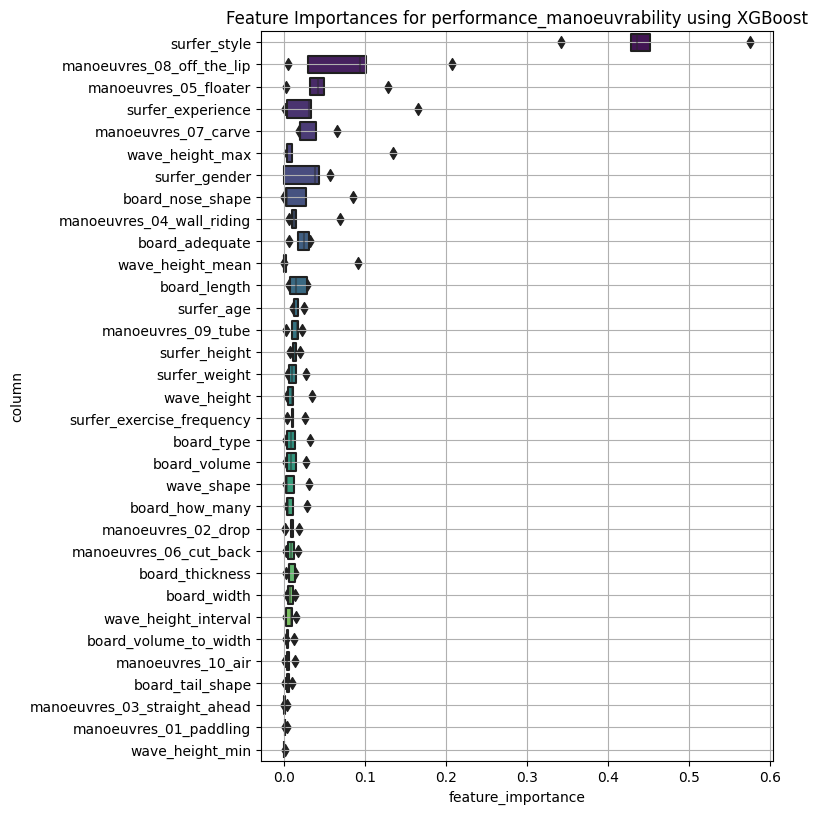

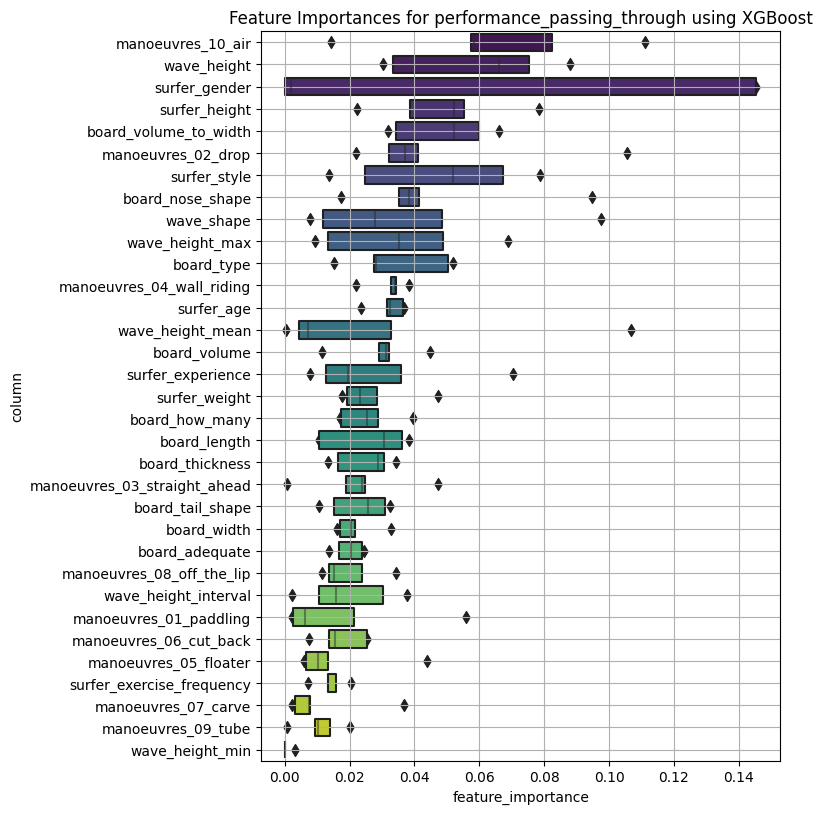

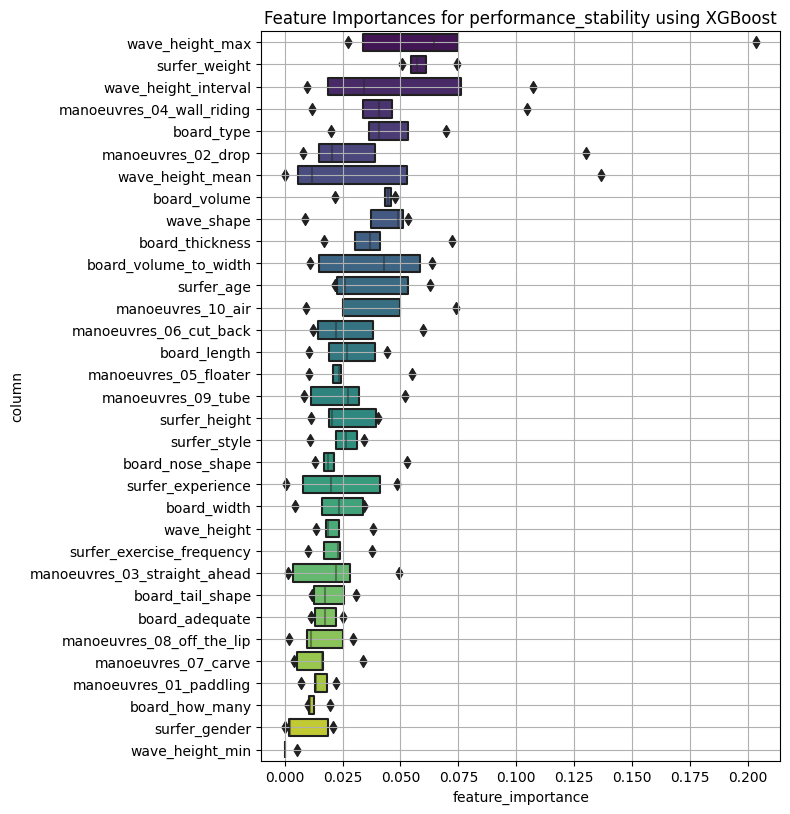

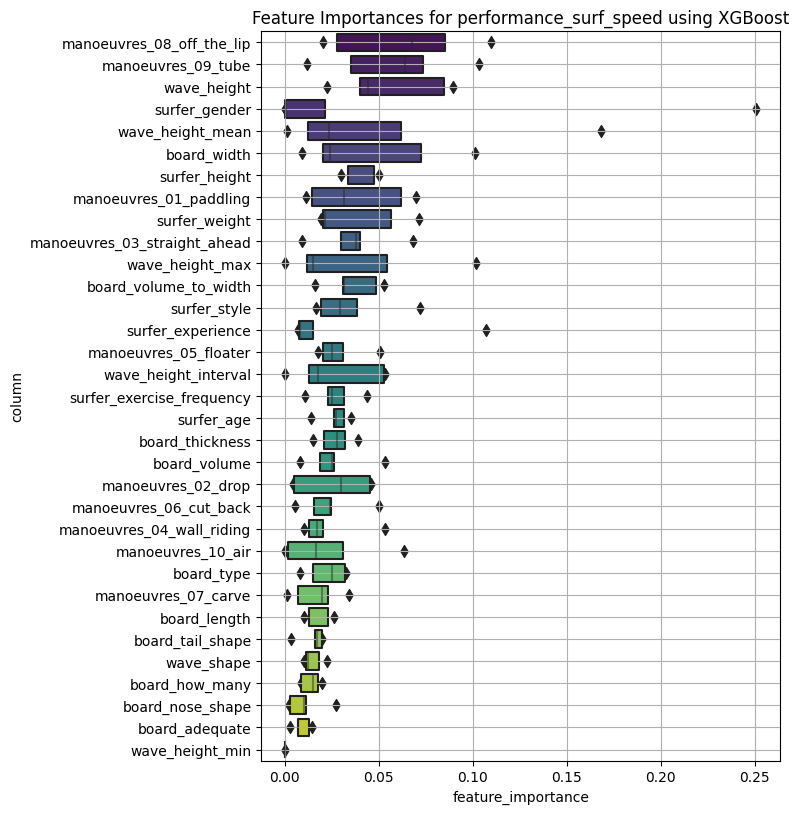

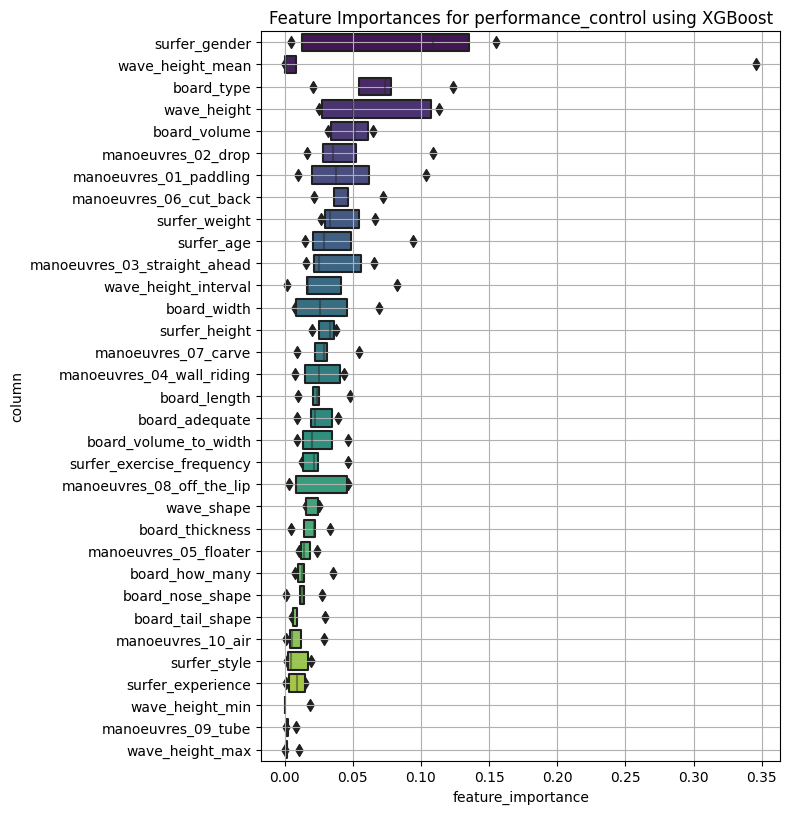

In [53]:
import xgboost as xgb

params_xgb = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'random_state': 42
}

for target_column in targets:
    plot_feature_importance(xgb.XGBRegressor, params_xgb, X_train, y_train[target_column], target_column, model_name='XGBoost')


### LightGBM Model

Average RMSE for LightGBM on performance_ease_paddling: 1.0354
Average MAE for LightGBM on performance_ease_paddling: 0.8786
--------------------------------------------------
Average RMSE for LightGBM on performance_flotation: 1.0691
Average MAE for LightGBM on performance_flotation: 0.8977
--------------------------------------------------
Average RMSE for LightGBM on performance_hold: 1.0947
Average MAE for LightGBM on performance_hold: 0.9262
--------------------------------------------------
Average RMSE for LightGBM on performance_manoeuvrability: 0.7826
Average MAE for LightGBM on performance_manoeuvrability: 0.6156
--------------------------------------------------
Average RMSE for LightGBM on performance_passing_through: 1.1988
Average MAE for LightGBM on performance_passing_through: 1.0126
--------------------------------------------------
Average RMSE for LightGBM on performance_stability: 1.1226
Average MAE for LightGBM on performance_stability: 0.9609
---------------------

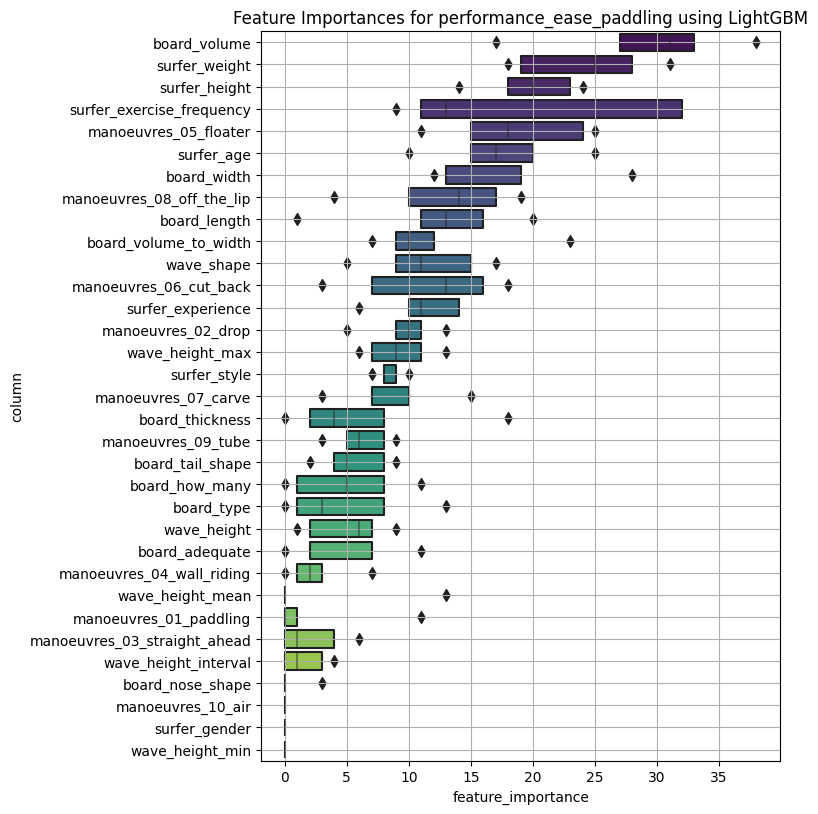

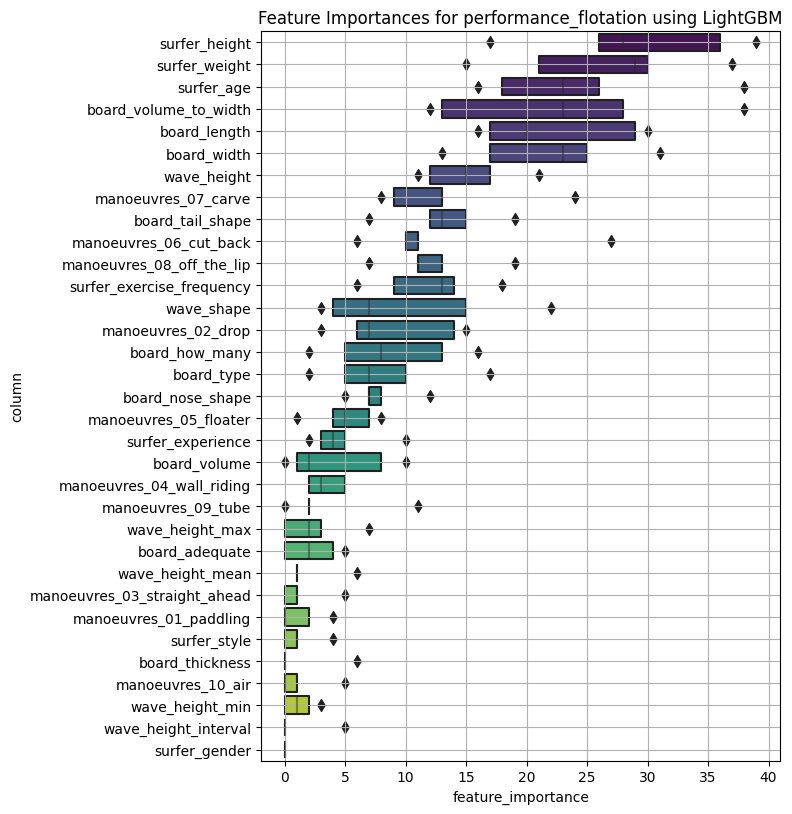

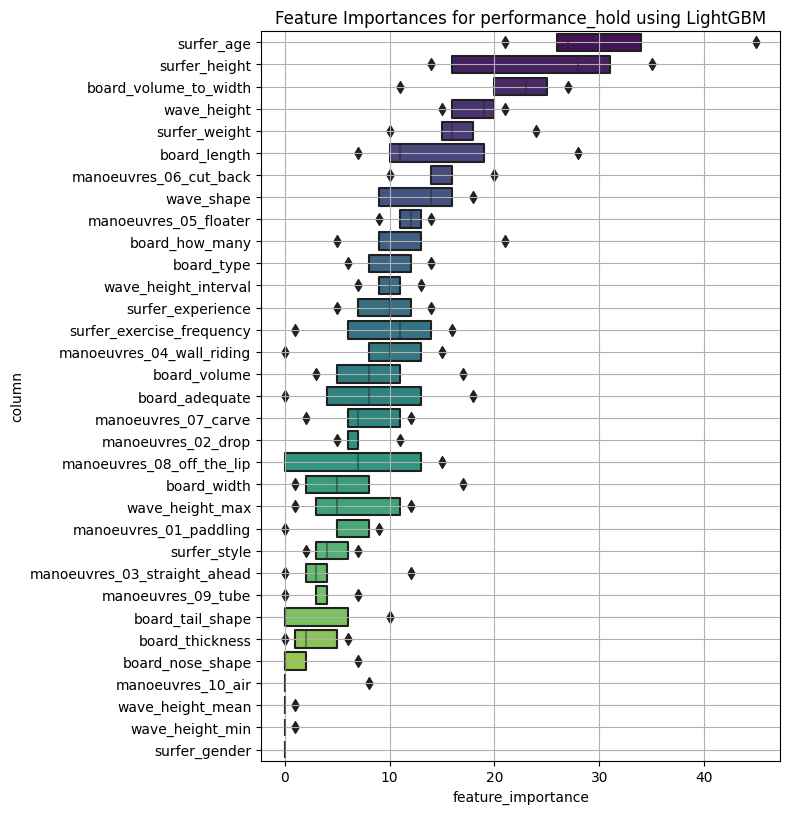

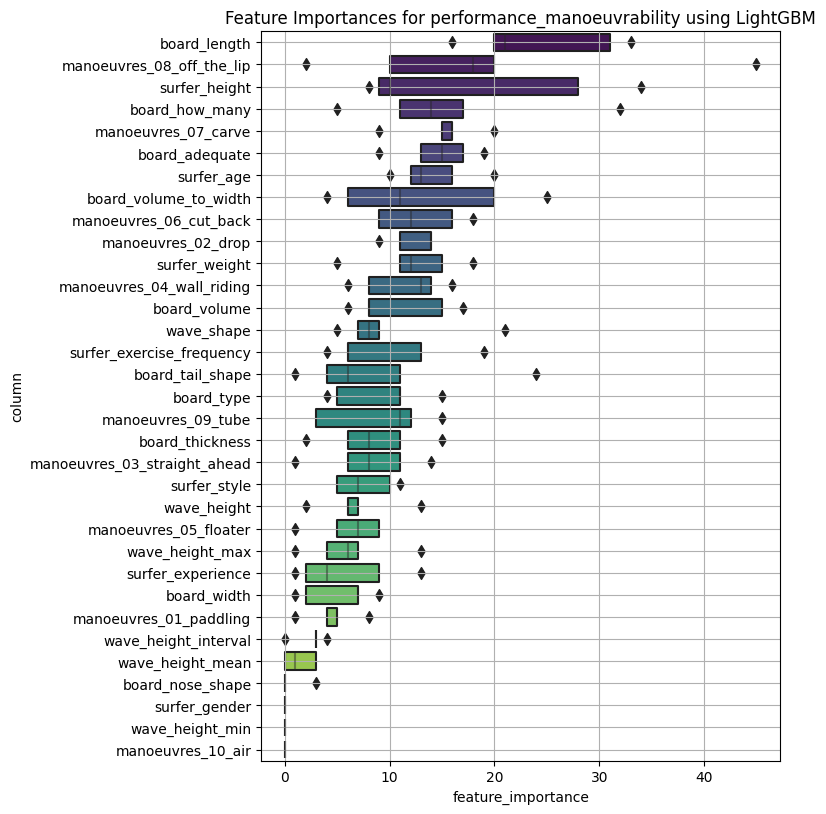

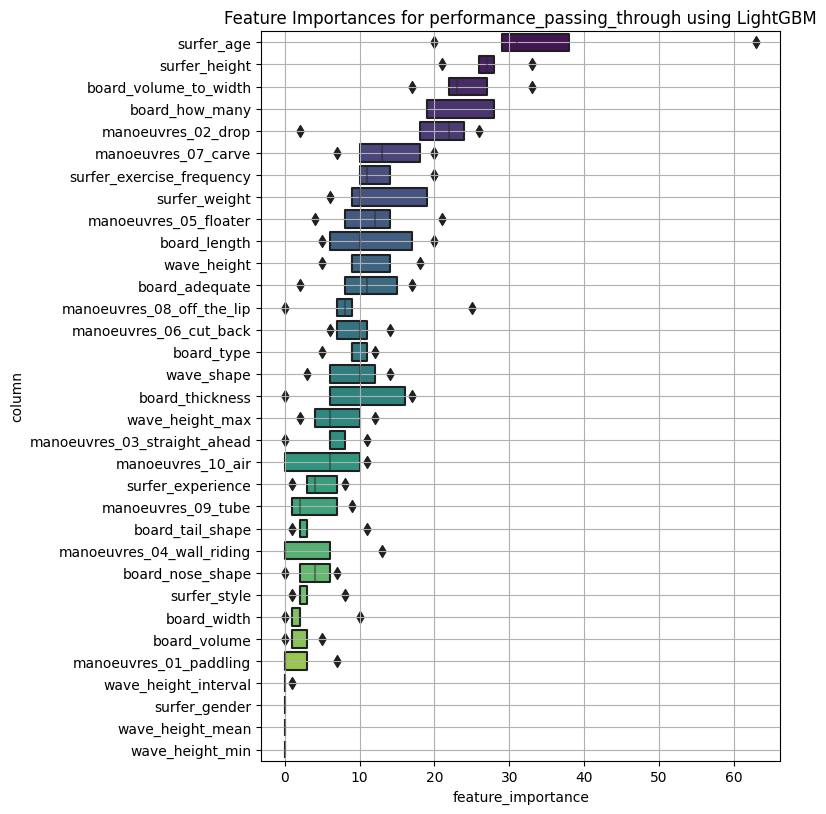

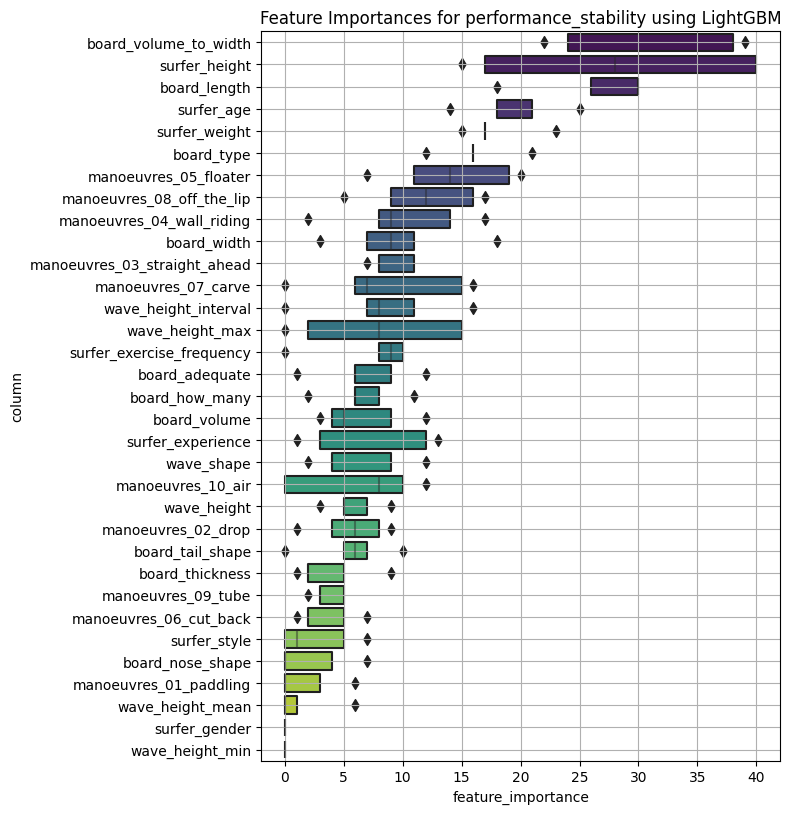

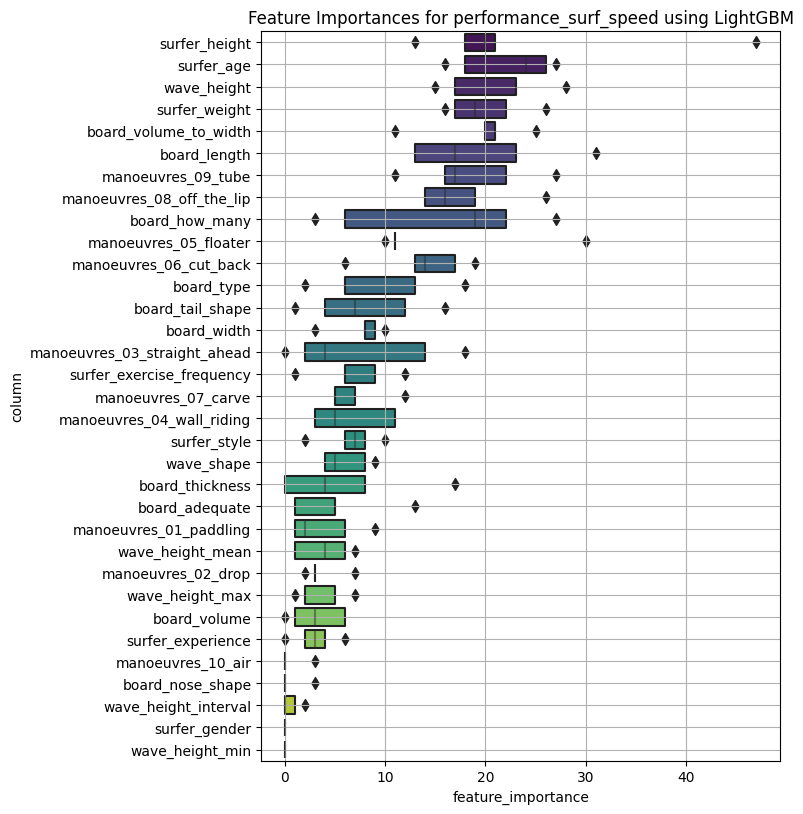

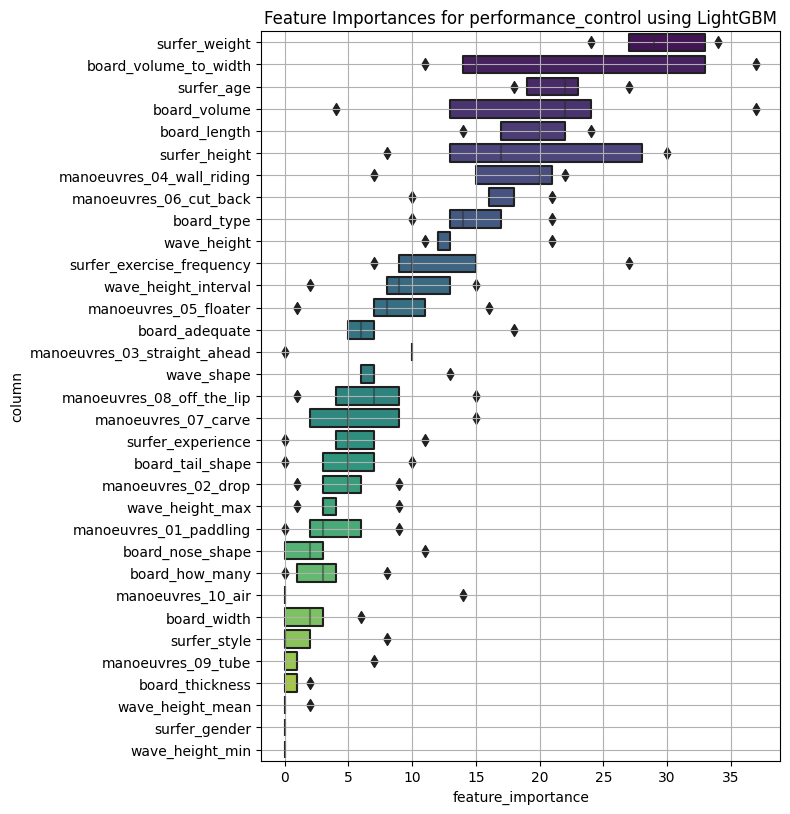

In [54]:
params = {
    'n_estimators': 100,
    'random_state': 42,
    'verbose': -1
}

for target_column in targets:
    plot_feature_importance(lgb.LGBMRegressor, params, X_train, y_train[target_column], target_column, model_name='LightGBM')
